## Exploratory Data Analysis of Gene Ontology using GO terms

Exploratory Data Analysis (EDA) of Gene Ontology (GO) using GO terms involves several steps to understand the underlying patterns and relationships in the data. Here are some steps you might take:

1. **Data Collection**: Obtain the GO annotations for genes of interest from a database like the Gene Ontology Consortium or other sources.

2. **Data Cleaning**: Check for and handle missing or incomplete annotations, remove duplicates, and ensure data integrity.

3. **Data Exploration**: 
   - Visualize the distribution of GO terms across genes.
   - Analyze the frequency of specific GO terms to identify the most common biological processes, molecular functions, and cellular components associated with the genes.

4. **Statistical Analysis**: 
   - Perform statistical tests to identify overrepresented or underrepresented GO terms compared to a background set of genes.
   - Use enrichment analysis tools (e.g., Fisher's exact test, hypergeometric test) to find significantly enriched GO terms.

5. **Clustering Analysis**: Use clustering techniques to group genes based on their GO annotations, which can reveal functional relationships among genes.

6. **Network Analysis**: Construct a network of GO terms or genes based on their relationships to identify functional modules or pathways.

7. **Visualization**: Use visualizations like heatmaps, bar charts, and network graphs to present the results of the analysis in an interpretable way.

8. **Annotation Enrichment Analysis**: Use tools like topGO, GOstats, or clusterProfiler in R or other similar tools to perform enrichment analysis on your GO terms.

9. **Functional Annotation Tools**: Use tools like DAVID, g:Profiler, or Enrichr to further explore the biological significance of your GO terms.

10. **Integration with Other Data**: Integrate GO analysis results with other omics data (e.g., gene expression, protein-protein interaction) to gain deeper insights into biological mechanisms.

By following these steps, you can gain a better understanding of the functional characteristics of genes based on their GO annotations and uncover valuable insights into biological processes, molecular functions, and cellular components.



In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import seaborn as sns
import umap
import matplotlib.pyplot as plt

In [3]:
# Core Wormcat Annotation Gene Categories
category_names_core=['Cell cycle', 'Chaperone', 'Cilia', 'Cytoskeleton', 'Development','DNA', 'Extracellular material', 
                     'Globin', 'Lysosome', 'Major sperm protein', 'Metabolism', 'mRNA functions','Muscle function', 
                     'Neuronal function', 'Nuclear pore', 'Nucleic acid', 'Peroxisome', 'Protein modification', 
                     'Proteolysis general', 'Proteolysis proteasome',  'Ribosome', 'Signaling', 'Stress response', 
                     'Trafficking', 'Transcription factor', 'Transcription: chromatin', 'Transcription: dosage compensation', 
                     'Transcription: general machinery']

# Poorly Annotated Genes Categories Wormcat
category_names_pag = ['Transcription: unassigned', 'Transmembrane protein', 'Transmembrane transport', 'Unassigned']

# Other Annotated Genes Categories Wormcat
category_names_other = ['Non-coding RNA', 'Pseudogene']

category_names_lst = category_names_core + category_names_pag + category_names_other


In [18]:
ontology_data_full_df = pd.read_csv("./input_data/wormbase_db/wb_gene_ontology_data.csv")
        

summary_df = ontology_data_full_df['go_term'].value_counts().reset_index()
summary_df = summary_df.rename(columns={'index': 'go_category'})
summary_df = summary_df.sort_values(by='go_category')

summary_df

,go_category,go_term
4543,'de novo' AMP biosynthetic process,2
6506,'de novo' CTP biosynthetic process,1
3171,'de novo' GDP-L-fucose biosynthetic process,3
1849,'de novo' IMP biosynthetic process,6
3141,'de novo' NAD biosynthetic process from trypto...,3
...,...,...
1412,zinc ion transport,8
6212,zonula adherens assembly,1
6829,zygote asymmetric cell division,1
3461,zymogen activation,2


In [7]:
category_names_pag = ['Transcription: unassigned', 'Transmembrane protein', 'Transmembrane transport', 'Unassigned']



In [19]:
ontology_data_full_df.columns

Index(['wormbase_id', 'go_id', 'go_category', 'go_term'], dtype='object')

In [20]:
go_counts = ontology_data_full_df['go_id'].value_counts()
go_mf_counts = ontology_data_full_df[ontology_data_full_df['go_category'] == 'Molecular_function']['go_id'].value_counts()
go_cc_counts = ontology_data_full_df[ontology_data_full_df['go_category'] == 'Cellular_component']['go_id'].value_counts()
go_bp_counts = ontology_data_full_df[ontology_data_full_df['go_category'] == 'Biological_process']['go_id'].value_counts()

print(f"Molecular_function {len(go_mf_counts):>5,}")
print(f"Cellular_component {len(go_cc_counts):>5,}")
print(f"Biological_process {len(go_bp_counts):>5,}")
print("="*25)
print(f"All                {len(go_counts):>5,}")


Molecular_function 2,246
Cellular_component   947
Biological_process 3,697
All                6,890


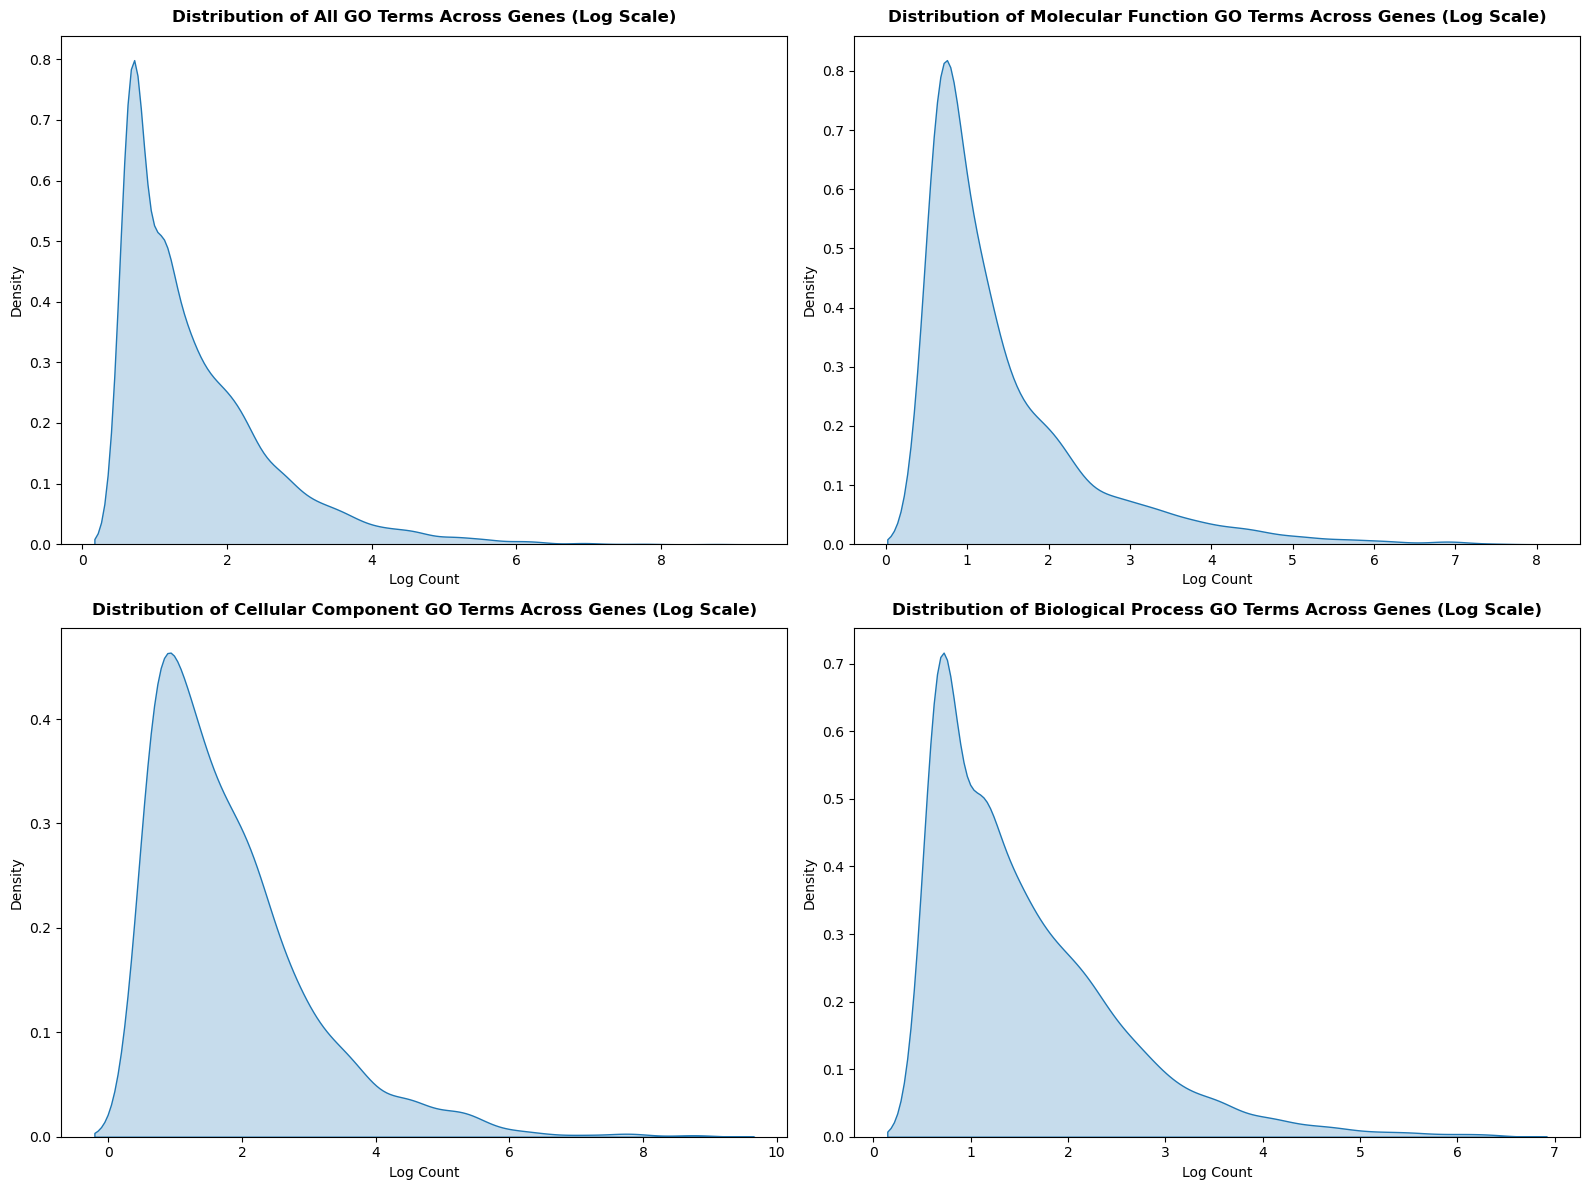

In [21]:
def plot_dist(data, category, subplot_index):
    plt.subplot(2, 2, subplot_index)
    log_counts = np.log1p(data)
    sns.kdeplot(data=log_counts, fill=True)
    plt.xlabel('Log Count')
    plt.ylabel('Density')
    plt.title(f"Distribution of {category} GO Terms Across Genes (Log Scale)", fontweight='bold', fontsize=12, pad=10)


plt.figure(figsize=(16, 12))

plot_dist(go_counts, "All", 1)
plot_dist(go_mf_counts, "Molecular Function", 2)
plot_dist(go_cc_counts, "Cellular Component", 3)
plot_dist(go_bp_counts, "Biological Process", 4)

plt.tight_layout()
plt.show()

In [22]:
ontology_data_full_df.head()

,wormbase_id,go_id,go_category,go_term
0,WBGene00010728,GO:0016020,Cellular_component,membrane
1,WBGene00010730,GO:0004864,Molecular_function,protein phosphatase inhibitor activity
2,WBGene00010730,GO:0005737,Cellular_component,cytoplasm
3,WBGene00010730,GO:0035308,Biological_process,negative regulation of protein dephosphorylation
4,WBGene00010730,GO:0007049,Biological_process,cell cycle


In [23]:
def one_hot_encode_ontology_data(genes_to_encode_df, go_category):
    #Create empty go terms dict
    unique_go_ids = ontology_data_full_df['go_id'].unique()
    empty_go_terms_dict = {go_term: 0 for go_term in unique_go_ids}

    genes_to_encode_ids = genes_to_encode_df['wormbase_id'].unique()

    one_hot_encoded_lst = []
    counter=0
    number_of_rows = len(genes_to_encode_ids)
    for wormbase_id in genes_to_encode_ids:
        print(".", end='')
        counter +=1
        go_terms_dict = empty_go_terms_dict.copy()
        go_terms_for_wb_id_df = ontology_data_full_df[(ontology_data_full_df['wormbase_id'] == wormbase_id) & (ontology_data_full_df['go_category'] == go_category)]
        for index, go_terms_for_wb_id_row in go_terms_for_wb_id_df.iterrows():
            go_terms_dict[go_terms_for_wb_id_row['go_id']]=1

        one_hot_list=list(go_terms_dict.values())
        row = [wormbase_id] + one_hot_list    
        one_hot_encoded_lst.append(row)

        # Show progress
        if counter % 100 == 0:
            print(f"{counter:>4} of {number_of_rows:>6,} {wormbase_id}")

    print(f"{counter:>4} of {number_of_rows:>6,}")

    one_hot_encoded_df = pd.DataFrame(one_hot_encoded_lst, columns=['Wormbase_Id']+list(go_terms_dict.keys()))
    return one_hot_encoded_df



In [28]:

def create_umap(one_hot_encoded_df):
    # Select only the GO annotations for clustering
    X = one_hot_encoded_df.drop('Wormbase_Id', axis=1)
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply UMAP to reduce the data to 2 dimensions
    umap_model = umap.UMAP(n_components=2)
    X_umap = umap_model.fit_transform(X_scaled)
    return X_umap

def plot_umap(X_umap, category, subplot_index):
    # Plot the UMAP visualization
    #plt.figure(figsize=(10, 6))
    plt.subplot(2, 2, subplot_index)
    plt.scatter(X_umap[:, 0], X_umap[:, 1], cmap='viridis', s=20, alpha=0.5)
    plt.xlabel('UMAP Component 1')
    plt.ylabel('UMAP Component 2')
    plt.title(f"UMAP Visualization of Genes Based on {category} GO Annotations", fontweight='bold', fontsize=12, pad=10)
    


In [33]:
len(X_umap)

1189

Encoding Cellular_component
.................................................................................................... 100 of  1,189 WBGene00007570
.................................................................................................... 200 of  1,189 WBGene00016420
.................................................................................................... 300 of  1,189 WBGene00017179
.................................................................................................... 400 of  1,189 WBGene00009183
.................................................................................................... 500 of  1,189 WBGene00018488
.................................................................................................... 600 of  1,189 WBGene00010485
.................................................................................................... 700 of  1,189 WBGene00044270
..............................................................

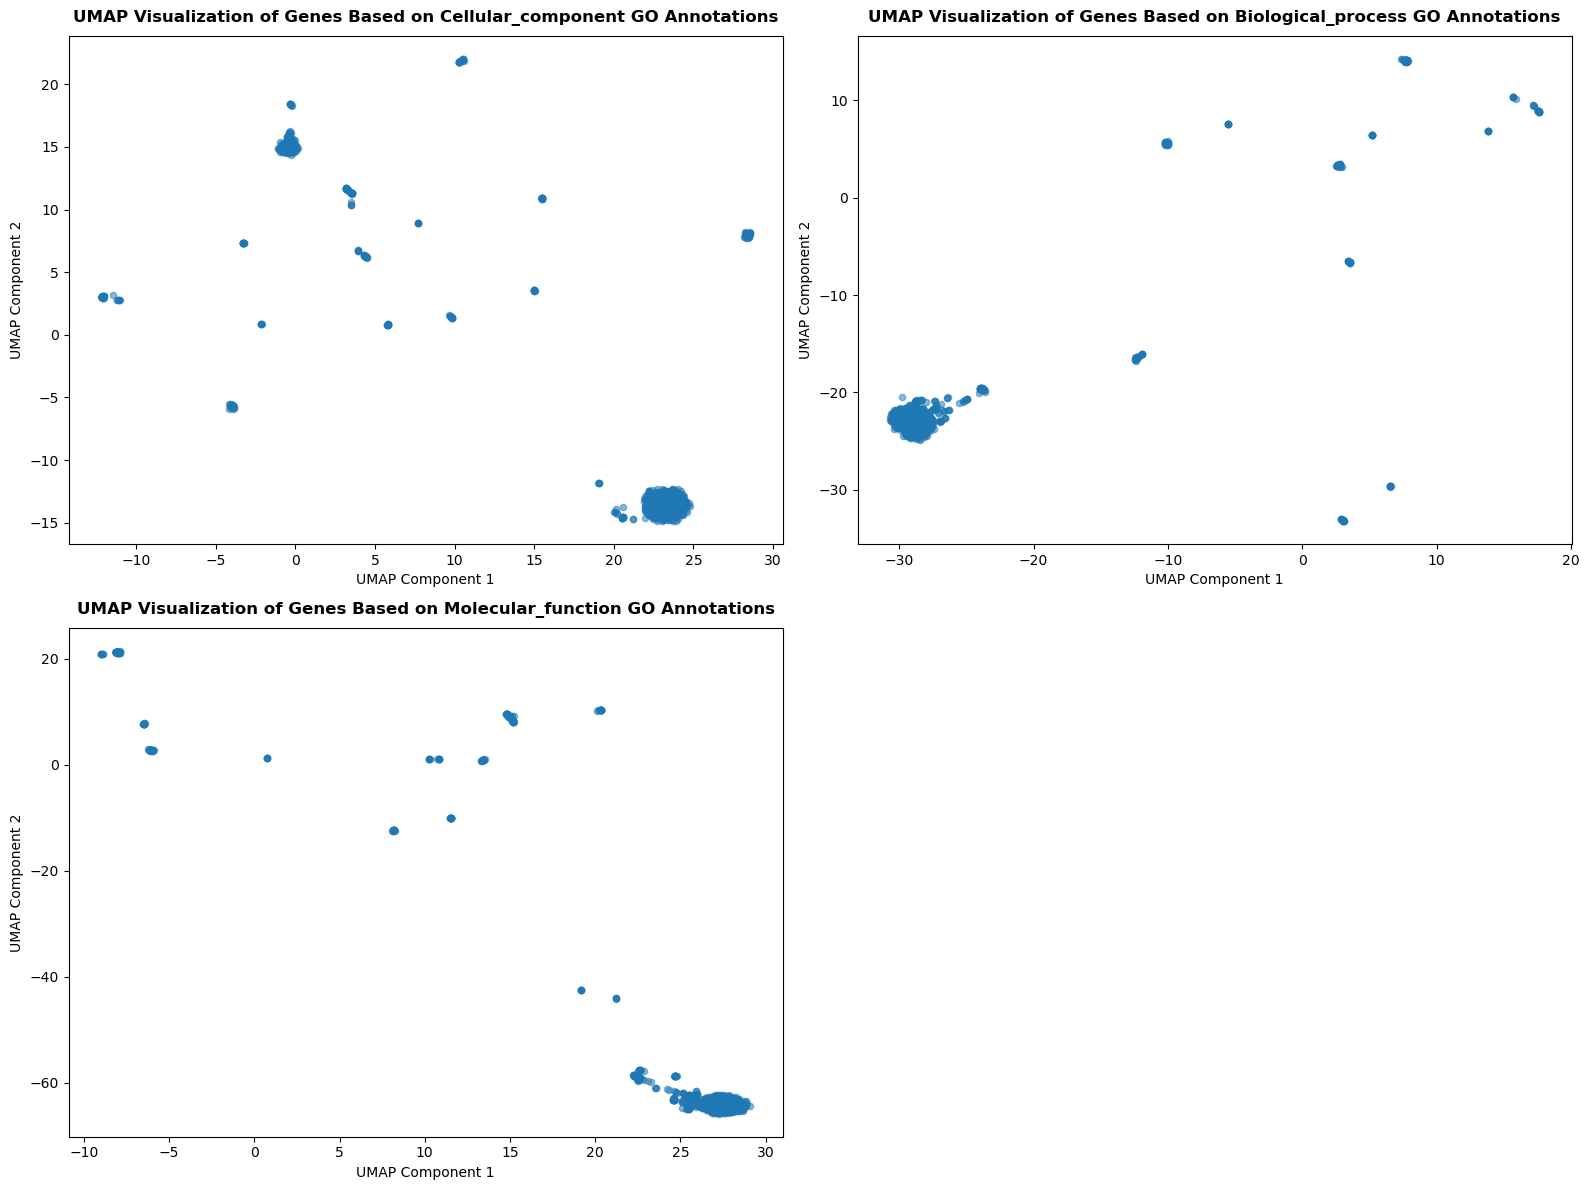

In [30]:
go_categories= ["Cellular_component", "Biological_process", "Molecular_function"]

genes_to_encode_df = pd.read_csv("./input_data/amys-sams-1-UP.csv")

plt.figure(figsize=(16, 12))
for index, go_category in enumerate(go_categories):
    print(f"Encoding {go_category}")
    one_hot_encoded_df = one_hot_encode_ontology_data(genes_to_encode_df, go_category)
    X_umap = create_umap(one_hot_encoded_df)
    plot_umap(X_umap, go_category, index+1)


plt.tight_layout()
plt.show()